# Single region analysis

This notebook provides an example of a full processing and analysis pipeline for a single region dataset.

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack, view_interactive_plot
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

## Parameters

### Input & output directories

In [3]:
dataroot = get_data_root()  # Root directory for raw data
figsdir = get_figs_dir()  # Directory for output figures
logger.info(f'input data root: "{dataroot}"')
logger.info(f'output figures directory: "{figsdir}"')
figs = {}  # Figures dictionary

 04/05/2022 20:06:35: input data root: "/Users/tlemaire/Documents/data/yiyuan/raw/line3/"
 04/05/2022 20:06:35: output figures directory: "/Users/tlemaire/Documents/data/figs/"


### Input dataset parameters

In [4]:
line = 'line3'  # mouse line
mouse = 'mouse12'  # mouse number
region = 'region1'  # brain region 
date = '11122019'  # experiment date

In [5]:
# Extract input data directory 
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory: "{datadir}"')

# Extract figures prefix
figsprefix = f'{line}{mouse}{region}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
logger.info(f'notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}')

 04/05/2022 20:06:35: input data directory: "/Users/tlemaire/Documents/data/yiyuan/raw/line3/11122019/mouse12/region1"
 04/05/2022 20:06:35: notebook started on 2022-05-04 at 20:06:35


### Input summary table figure

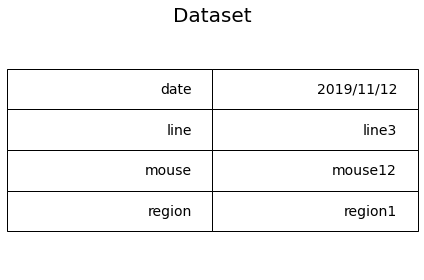

In [6]:
figs['dataset_info'] = plot_table({
    'date': f'{date[4:]}/{date[:2]}/{date[2:4]}',
    'line': line,
    'mouse': mouse,
    'region': region
    })

### Intermediate data inspection

In [7]:
irun_inspect = None  # run index
nROIs_inspect = 3  # number of ROIs to look at for the inspection run (if specified)
irun_eq = None  # equivalent run index from suite2p output 
stacktitle = f'run {irun_inspect}'  # default stack title
stackdict = None  # empty stacks dictionary
runbounds = None  # empty runbounds array
istimframes_stacked = None  # empty stimulus frames array
save_gifs = False  # whether to save gifs of extracted movies or not

## Pre-processing (stacking, substitution, denoising)

### Gather data folders & extract acquisition settings

In [8]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References', 'incomplete'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

# Extract acquisition settings from each run
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 04/05/2022 20:06:36: /Users/tlemaire/Documents/data/yiyuan/raw/line3/11122019/mouse12/region1
 04/05/2022 20:06:36: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-861',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-858',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-863',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-867',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-857',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-868',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-864',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-859',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-866']
 04/05/2022 20:06:36: extractin

{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (311.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 1.11, 'YAxis': 2.06, 'ZAxis': 0.05},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rasters

### Merge TIFs into stack

In [9]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot stack summary frames
    figs[f'raw_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        raw_stack, title=f'run {irun_inspect} - raw stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'raw_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack}, title=f'run {irun_inspect} - raw stack')

    # Plot stack frequency spectrum
    figs[f'raw_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw': raw_stack},  1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - raw stack')

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

 04/05/2022 20:06:38: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 04/05/2022 20:06:38: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 04/05/2022 20:06:38: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 04/05/2022 20:06:39: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 04/05/2022 20:06:39: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 04/05/2022 20:06:39: "/Users/tlemaire/Documents/data/yiyuan/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865.

### Substitute stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [10]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load interpolated stack for the same run
    subsituted_stack = loadtif(substituted_stack_fpaths[irun_inspect])

    # Plot interpolated stack summary frames
    figs[f'interp_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        subsituted_stack, title=f'run {irun_inspect} - {si} substituted stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'interp_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack, 'substituted': subsituted_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'interp_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw': raw_stack, 'substituted': subsituted_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'interp_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'substituted': substituted_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw and inteprolated stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        si: substituted_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/D

### Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [11]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot denoised stack summary frames
    figs[f'filtered_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        filtered_stack, title=f'run {irun_inspect} - {kd} filtered stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot comparative stack histograms
    figs[f'filtered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'filtered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 04/05/2022 20:06:40: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200

## Functional segmentation (suite2p)

 04/05/2022 20:06:40: parsed frame rate = 3.56 fps
 04/05/2022 20:06:40: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1
 04/05/2022 20:06:40: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 04/05/2022 20:06:40: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 04/05/2022 20:06:40: found all suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 04/05/2022 20:06:40: run options match 100% -> ignoring
 04/05/2022 20:06:40: empty data path -> no run
 04/05/2022 20:06:40: extracted data contains 880 ROIs
 04/05/2022 20:06:40: output info table corresponding to suite2p processing order:
      line  trial_length  duration (s)   fps  P 

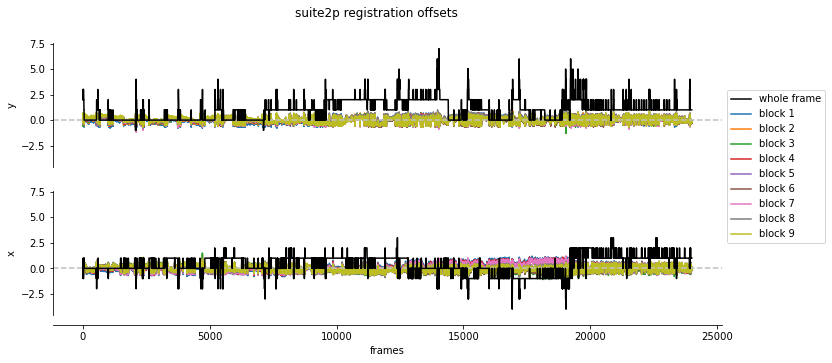

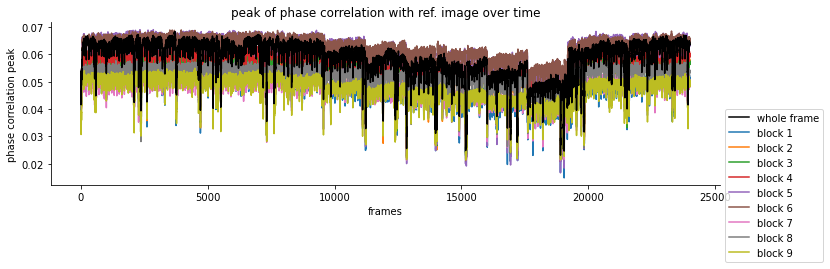

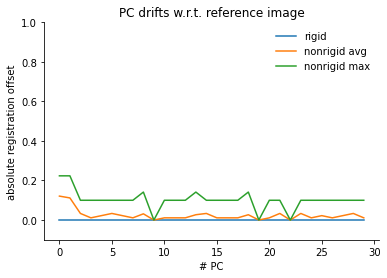

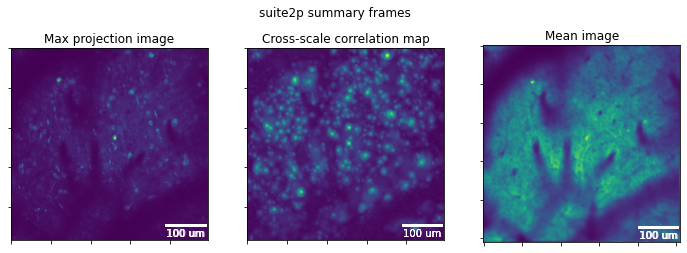

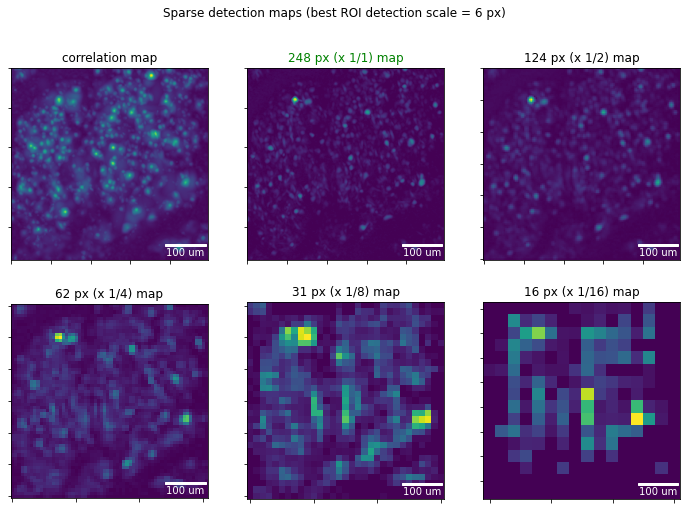

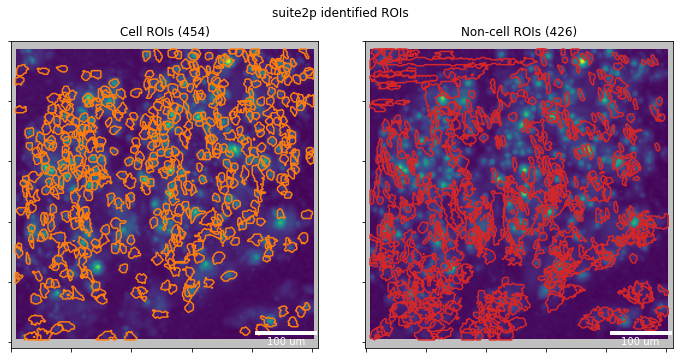

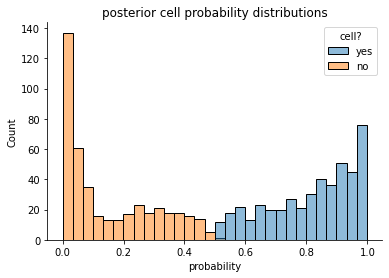

In [12]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info('output info table corresponding to suite2p processing order:')
print(output_info_table)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot stack histogram
    figs[f'registered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        title=f'run {irun_inspect} - stacks comparison')
    
    # Plot stack frequency spectrum
    figs[f'registered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=daq_settings['micronsPerPixel'])

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'], mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing (raw F traces to z-score traces)

### Load processed data if available

In [13]:
postpro_outdir = os.path.join(s2p_input_dirs[0], s2p_basedir, 'processed')
is_postpro_data_available = check_data(postpro_outdir, nruns)
if is_postpro_data_available:
    logger.info('loading data...')
    Ftimeseries, output_info_table, ROI_masks = load_data(postpro_outdir, nruns)
    logger.info(f'experiment info table:\n{output_info_table}')
    logger.info(f'z-scores timeseries: {describe_dataframe_index(Ftimeseries)} dataframe')
    logger.info(f'ROI masks: {describe_dataframe_index(ROI_masks)} dataframe')

 04/05/2022 20:06:44: processed data not found in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/processed" directory


### Get fluorescence timeseries data

 04/05/2022 20:06:45: assembled (880 ROIs x 24000 frames) fluorescence timeseries dataframe
 04/05/2022 20:06:45: splitting fluorescence data into 15 separate runs...
 04/05/2022 20:06:50: reshaped dataframe into (880 ROIs x 15 runs x 1600 frames) form
 04/05/2022 20:06:50: splitting fluorescence data into 16 separate trials...
 04/05/2022 20:06:56: reshaped dataframe into (880 ROIs x 15 runs x 16 trials x 100 frames) form
 04/05/2022 20:06:57: filtered data (880 ROIs x 15 runs x 16 trials x 100 frames)
 04/05/2022 20:06:57: discarding non-cell ROIs...
 04/05/2022 20:06:58: filtered to 454 ROIs x 15 runs x 16 trials x 100 frames fluorescence timeseries dataframe
 04/05/2022 20:06:58: updating dataset...
 04/05/2022 20:06:59: filtered to 453 ROIs x 15 runs x 16 trials x 100 frames fluorescence timeseries dataframe
 04/05/2022 20:06:59: plotting suite2p identified ROIs...
 04/05/2022 20:07:00: plotting F_ROI (a.u.) traces of all ROIs...
 04/05/2022 20:07:01: identified 1 invalid ROI(s):


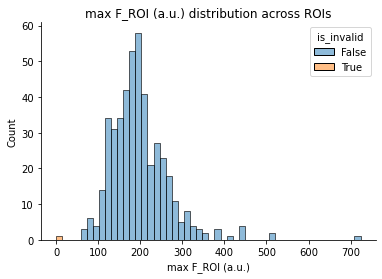

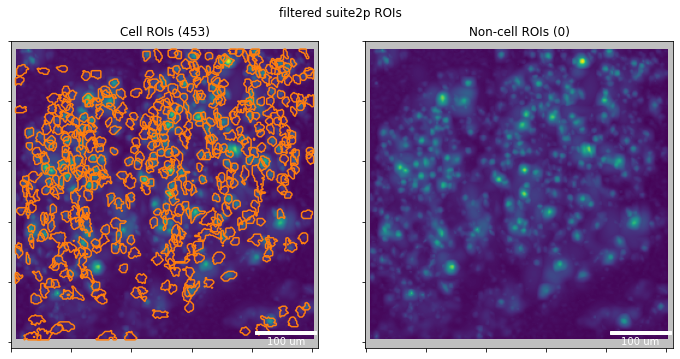

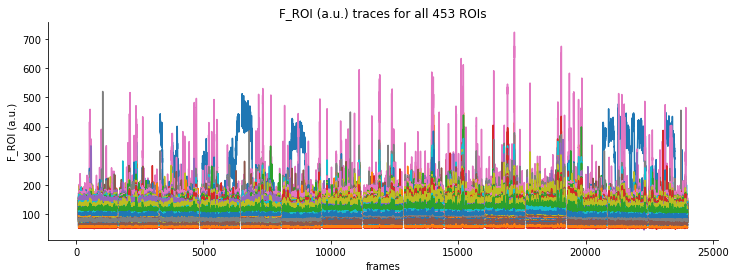

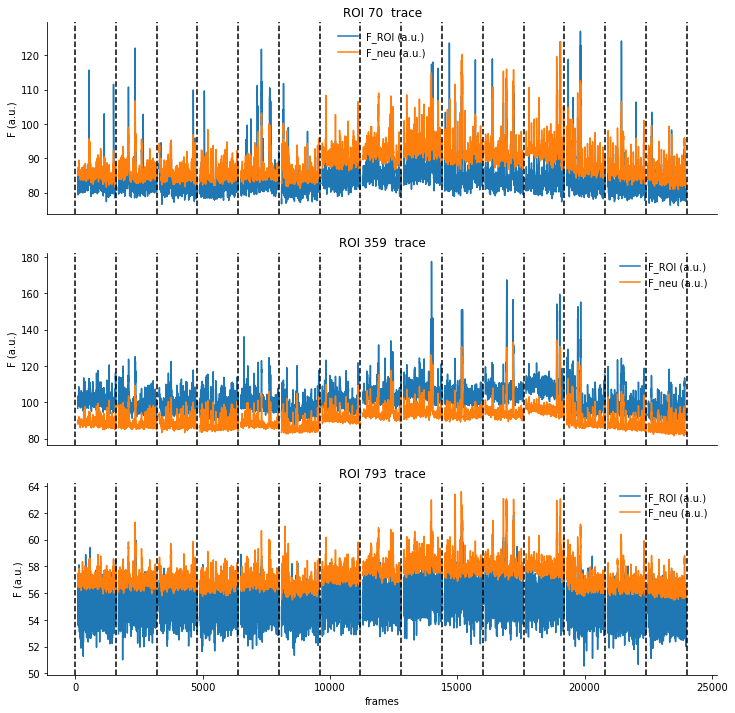

In [14]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
Ftimeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(Ftimeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
Ftimeseries = separate_runs(Ftimeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(Ftimeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
Ftimeseries = separate_trials(Ftimeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(Ftimeseries)}) form')

# Discard first trial of each run
# NOTE: on the acquisition side, nothing is wrong with the first trial of each condition.
# However, since the different runs were fed together into suite2p (in order to improve ROI identification),
# the resulting fluorescence timecourses for each ROI were computed by suite2p under the assumption of
# time continuity, which is NOT the case during run-to-run transitions. We therefore discard the first trial
# of each run, since the fluorescence data is physiologically invalid around these transitions.
from constants import ITRIALS_DISCARD
Ftimeseries = remove_trials(Ftimeseries, iremove=ITRIALS_DISCARD)
logger.info(f'filtered data ({describe_dataframe_index(Ftimeseries)})')

# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
Ftimeseries = Ftimeseries.loc[(icells)]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = Ftimeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Identify invalid ROIs with zero F_ROI range 
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
Ftimeseries = Ftimeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F_ROI)

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = Ftimeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    iROI_inspect = np.random.choice(iROIs, size=nROIs_inspect)
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # # Find run with high P and DC to plot
    # irun_plt = output_info_table[
    #     (output_info_table[Label.P] == P_REF) & (output_info_table[Label.DC] == DC_REF)
    #     ].index[0]
    # logger.info(f'selecting run {irun_plt} with parameters P = {P_REF:.2f} MPa and DC = {DC_REF:.0f} % for plotting')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_traces(
        Ftimeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

Ftimeseries

### Compute neuropil-corrected fluorescence data

 04/05/2022 20:07:06: computing alphas minimizing center_around(0.7) function within (0.2, 2) interval...


453it [00:02, 224.55it/s]                         

 04/05/2022 20:07:08: subtracting neuropil background...


 04/05/2022 20:07:09: sub-indexing data...
 04/05/2022 20:07:09: filtering data...
 04/05/2022 20:07:09: cross-checking filters...
 04/05/2022 20:07:09: plotting 1 fluorescence trace(s)...
 04/05/2022 20:07:09: adding 16 delimiters
 04/05/2022 20:07:09: plotting F (a.u.) traces of all ROIs...


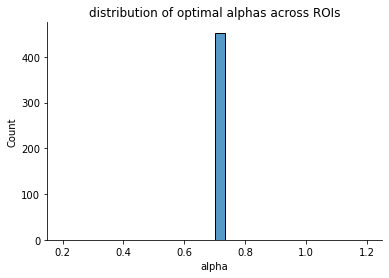

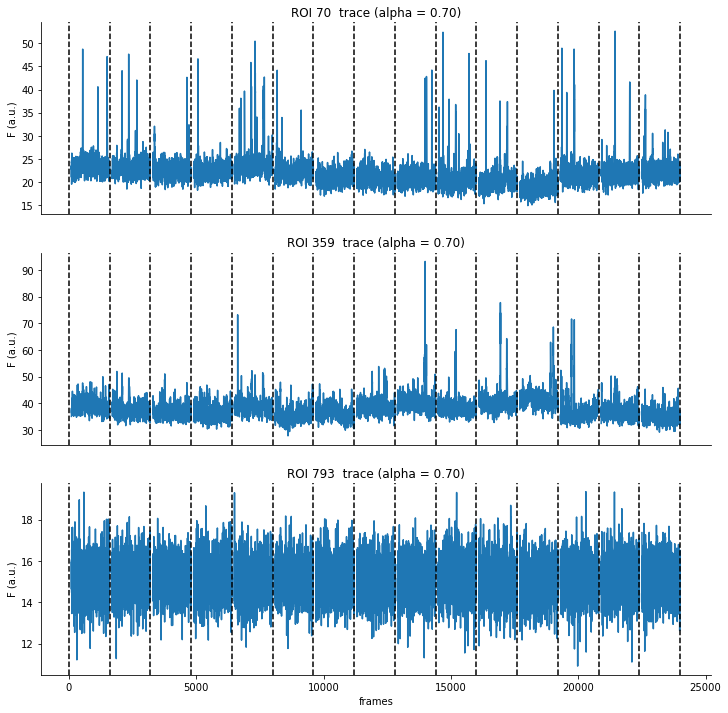

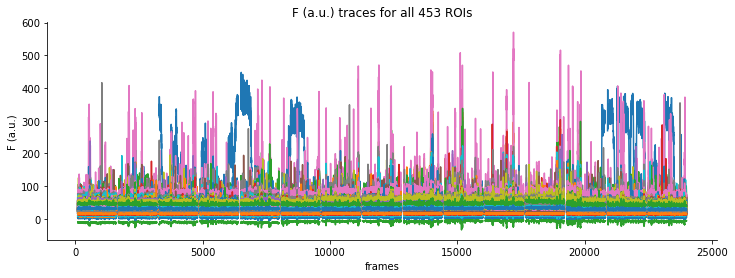

In [15]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients minimizing specific cost function
from constants import ALPHA
nROIs = len(Ftimeseries.index.unique(Label.ROI))
costfunc = force_positive_Fc(center_around(ALPHA))
alpha_bounds = (0.2, 2)
logger.info(f'computing alphas minimizing {costfunc.__name__} function within {alpha_bounds} interval...')
with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
    alphas = Ftimeseries.groupby(Label.ROI).apply(
        pbar_update(lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds), pbar))
alphas = alphas.rename(Label.ALPHA)

# logger.info(f'computing linear regressions for F_ROI vs. F_NEU...')
# # Compute linear regressions between ROI and neuropil fluorescence profiles
# nROIs = len(Ftimeseries.index.unique(Label.ROI))
# with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
#     linreg_coeffs = Ftimeseries.groupby(Label.ROI).apply(
#         pbar_update(linreg, pbar))
# # Reorganize fitted coefficients into dataframe
# linreg_coeffs = pd.DataFrame(
#     linreg_coeffs.tolist(),
#     columns=[Label.BETA, Label.ALPHA],
#     index=linreg_coeffs.index)
# # Plot joint distribution of alpha and F0
# fg = sns.jointplot(x=Label.ALPHA, y=Label.BETA, data=linreg_coeffs)
# figs['linreg_fits'] = fg.figure

# # Plot linear regression fit for subset of selected ROIs
# figs['linregs'] = plot_linreg(Ftimeseries, iROI_inspect)

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.histplot(alphas.to_frame(), x=Label.ALPHA, ax=ax, bins=30)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
Ftimeseries[Label.F] = Ftimeseries[Label.F_ROI] - alphas * Ftimeseries[Label.F_NEU]

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    figs['F_trace'] = plot_traces(
        Ftimeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters,
        title=[f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt])
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1], color='silver', alpha=0.5)

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a low percentile sliding window and (2) an average sliding window, over the entire fluorescence timecourse. This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

For downstream analysis steps, we wish to consider only cells who exhibit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

The remaining fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

 04/05/2022 20:07:14: computing signal baseline as successive application of:
  - 5th percentile of 15.0s (53 frames) sliding window
  - mean of 7.6s (27 frames) sliding window


6795it [00:56, 120.88it/s]                          

 04/05/2022 20:08:10: computing baseline relative standard deviation...


 04/05/2022 20:08:11: identifying outliers...
 04/05/2022 20:08:12: updating dataset...
 04/05/2022 20:08:12: filtered to 449 ROIs x 15 runs x 16 trials x 100 frames fluorescence dataframe
 04/05/2022 20:08:12: subtracting mean-corrected baseline from signals...
 04/05/2022 20:08:22: identified 4 outlier(s):


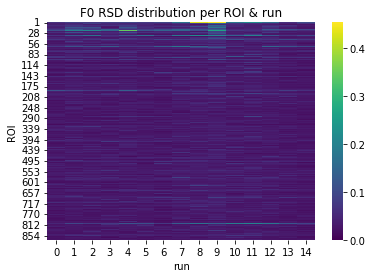

In [16]:
%%skip $is_postpro_data_available

from constants import BASELINE_WLEN, BASELINE_QUANTILE, BASELINE_RSD_THR
Ftimeseries[Label.F0] = compute_baseline(
    Ftimeseries[Label.F], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.nanstd(x) / np.abs(np.nanmean(x)))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis')
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence dataframe')

# Mean correction of remaining signals
logger.info('subtracting mean-corrected baseline from signals...')
# Compute mean baseline value per ROI & run
F0_mean = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
# Apply baseline corretor to both fluorescence and baseline signals
baseline_corrector = Ftimeseries[Label.F0] - F0_mean
Ftimeseries[Label.F] -= baseline_corrector
Ftimeseries[Label.F0] -= baseline_corrector

# Plot baseline-corrected fluorescence signal and baseline of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}_corrected'] = plot_traces(
        Ftimeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title='after baseline correction')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### ΔF/F0 computation

In [17]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).median()  # median of the baseline over each run
Ftimeseries[Label.DFF] = (Ftimeseries[Label.F] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)

 04/05/2022 20:08:23: computing relative change in fluorescence...


### Z-score computation

 04/05/2022 20:08:38: fitting gaussians to dFF histogram distributions...


6735it [00:40, 166.00it/s]                          

 04/05/2022 20:09:19: extracting fitted gaussian parameters...


 04/05/2022 20:09:19: normalizing dFF by gaussian parameters to compute z-scores...


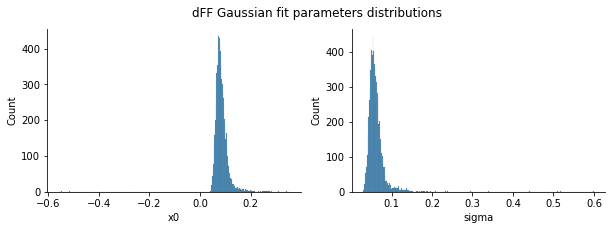

In [18]:
%%skip $is_postpro_data_available

# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
nROIs, nruns = [len(Ftimeseries.index.unique(k)) for k in [Label.ROI, Label.RUN]]
with tqdm(total=nROIs * nruns - 1, position=0, leave=True) as pbar:
    dFF_histfits = Ftimeseries[Label.DFF].groupby([Label.ROI, Label.RUN]).agg(
        pbar_update(nan_proof(gauss_histogram_fit), pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot histogram distributions of the relevant extracted Gaussian parameters
mkeys = ['x0', 'sigma']
figs['gaussianfits_dists'], axes = plt.subplots(1, len(mkeys), figsize=(5 * len(mkeys), 3))
figs['gaussianfits_dists'].suptitle('dFF Gaussian fit parameters distributions')
for ax, mk in zip(axes, mkeys):
    sns.despine(ax=ax)
    sns.histplot(dFF_histparams, x=mk, ax=ax)

# Plot dFF histogram distribution and fitted gaussian parameters for each ROI of interest 
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_hist_fits_run{irun_inspect}'] = plot_gaussian_histogram_fit(
        Ftimeseries, dFF_histparams, iROI_inspect, irun_eq, nbins=nbins)

# Normalize dFF traces by gaussian parameters to obtain dFF z-scores
logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
Ftimeseries[Label.ZSCORE] = (Ftimeseries.loc[:, Label.DFF] - dFF_histparams['x0']) / dFF_histparams['sigma']

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Save z-score data

In [19]:
%%skip $is_postpro_data_available

# Reduce timeseries data to z-scores only
Ftimeseries = Ftimeseries.loc[:, [Label.ZSCORE]]
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], Ftimeseries.index.unique(level=Label.ROI))
# Save data in output directory
save_data(Ftimeseries, output_info_table, ROI_masks, postpro_outdir)

 04/05/2022 20:09:36: creating "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/processed" folder...
 04/05/2022 20:09:36: saving experiment info table...
 04/05/2022 20:09:37: saving z-score data for run 0...
 04/05/2022 20:09:38: saving z-score data for run 1...
 04/05/2022 20:09:39: saving z-score data for run 2...
 04/05/2022 20:09:41: saving z-score data for run 3...
 04/05/2022 20:09:43: saving z-score data for run 4...
 04/05/2022 20:09:45: saving z-score data for run 5...
 04/05/2022 20:09:46: saving z-score data for run 6...
 04/05/2022 20:09:48: saving z-score data for run 7...
 04/05/2022 20:09:50: saving z-score data for run 8...
 04/05/2022 20:09:51: saving z-score data for run 9...
 04/05/2022 20:09:53: saving z-score data for run 10...
 04/05/2022 20:09:55: saving z-score data for run 11...
 04/05/2022 20:09:57: saving z-score data for run 12...
 04/05/2022 20:09:58: savi

## Statistics (response metrics & cell classification)

### Create statistics dataframe

<span style="color:yellow">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [20]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: Ftimeseries.index.unique(k) for k in Ftimeseries.index.names}

# Create Fstats dataframes
logger.info('creating statistics dataframe')
Fstats = pd.DataFrame()

# Add discarded labels (frist trial of each condition, from 2nd condition onward)
logger.info('adding "discarded" labels...')
Fstats[Label.DISCARDED] = ~Ftimeseries[Label.ZSCORE].groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).first().notna()

# Add information about pule and time-average acoustic intensity to info table
output_info_table = add_intensity_to_table(output_info_table)

# Add experimental info to Fstats
if Label.P not in Fstats:
    logger.info('adding experimental info to Fstats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels([Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    Fstats = pd.concat([exp_output_table, Fstats], axis=1) 

logger.info('Fstats table:')
Fstats

 04/05/2022 20:10:02: creating statistics dataframe
 04/05/2022 20:10:02: adding "discarded" labels...
 04/05/2022 20:10:03: deriving acoustic intensity information...
 04/05/2022 20:10:03: adding experimental info to Fstats...
 04/05/2022 20:10:03: Fstats table:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
1   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
878 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  
ROI run trial                                                     
1   0   0         869        0.000000         0.00000       True  
        1         869        0.000000         0.00000      False  
        2         869        0.000000         0.00000      False  
        3         869        0.000000         0.00000      False  
        4         869        0.000000         0.00000      False  
...               ...             ...             ...        ...  
878 14  11        863       19.784475        15.82758      False  
        12        863       19.784475        15.82758      False  
        13        863       19.784475        15.82758      False  
        14        863       19.784475        15.82758      False  
        15        863       19.784475        15.82758      False  

[107760 rows x 10 columns]

### Visualize stimulation protocol

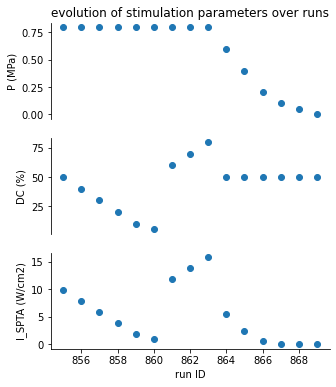

In [21]:
figs['protocol_summary'] = plot_protocol(
    output_info_table,
    xkey=Label.RUNID,
    ykeys=(Label.P, Label.DC, Label.ISPTA))

### Stimulus-evoked motion artefact characterization & rejection

 04/05/2022 20:10:03: computing diplacement velocity over time from registration offsets...
 04/05/2022 20:10:03: correcting displacement velocity at stimulus indexes to compensate for stimulus frames substitution...
 04/05/2022 20:10:04: identified 25 / 240 trials (10.4%) with significant displacement:


peak displacement velocity (um/s)  motion  P (MPa)  DC (%)  \
run trial                                                               
2   15                              7.875386    True     0.20    50.0   
3   5                               4.577124    True     0.40    50.0   
    7                               7.126205    True     0.40    50.0   
4   12                              4.471345    True     0.05    50.0   
5   3                               2.517454    True     0.60    50.0   
    15                              3.378898    True     0.60    50.0   
7   12                              3.639877    True     0.80    10.0   
8   2                               2.387449    True     0.80    20.0   
    12                              3.224757    True     0.80    20.0   
10  0                               3.172362    True     0.80    40.0   
    8                               2.232228    True     0.80    40.0   
    9                               4.691655    True     0.80    40.0   
    12                              7.695944    True     0.80    40.0   
    14                              4.312271    True     0.80    40.0   
11  14                              4.220845    True     0.80    50.0   
    15                              4.162615    True     0.80    50.0   
12  3                               3.243228    True     0.80    60.0   
    4                               2.151343    True     0.80    60.0   
    6                               2.676304    True     0.80    60.0   
    12                              2.093230    True     0.80    60.0   
13  6                               2.695206    True     0.80    70.0   
    8                               2.653185    True     0.80    70.0   
14  7                               2.015805    True     0.80    80.0   
    9                               2.122810    True     0.80    80.0   
    15                              2.407584    True     0.80    80.0   

           I_SPTA (W/cm2)  
run trial                  
2   15           0.618265  
3   5            2.473059  
    7            2.473059  
4   12           0.038642  
5   3            5.564384  
    15           5.564384  
7   12           1.978448  
8   2            3.956895  
    12           3.956895  
10  0            7.913790  
    8            7.913790  
    9            7.913790  
    12           7.913790  
    14           7.913790  
11  14           9.892238  
    15           9.892238  
12  3           11.870685  
    4           11.870685  
    6           11.870685  
    12          11.870685  
13  6           13.849133  
    8           13.849133  
14  7           15.827580  
    9           15.827580  
    15          15.827580

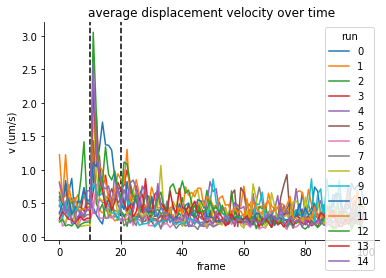

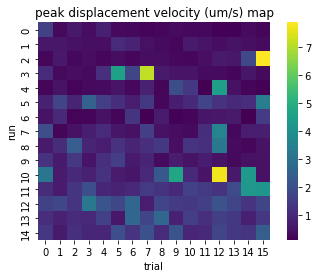

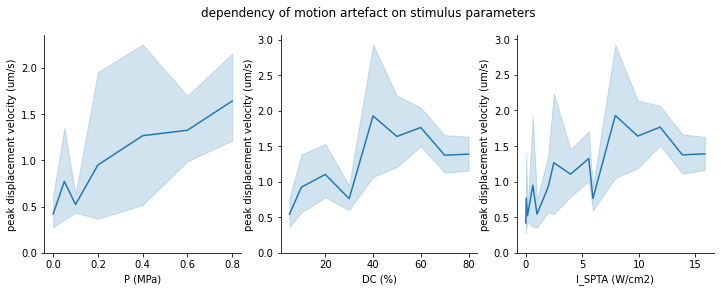

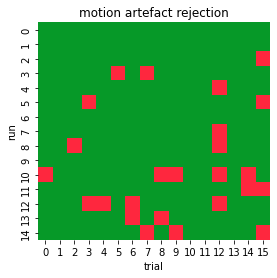

In [22]:
# Create (run, trial, frame) multi-index
exp_mux = pd.MultiIndex.from_product(
    [np.arange(nruns), np.arange(ntrials_per_run), np.arange(NFRAMES_PER_TRIAL)],
    names=[Label.RUN, Label.TRIAL, Label.FRAME])
# Compute displacement velocity profiles
is_substituted = isinstance(si, StackInterpolator)
vdisp = compute_displacement_velocity(
    s2p_ops, exp_mux, 
    daq_settings['micronsPerPixel'],
    1 / daq_settings['framePeriod'],
    substituted=is_substituted)

# Plot average displacement velocity profile for each run
figs['vdisp_profiles'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('average displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    hue=Label.RUN, ci=None, palette='tab10')

# Compute peak of displacement velocity within response window for each run and trial
# and assess of motion exceeded threshold
from constants import VDISP_THR
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_peaks = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(find_response_peak).rename(Label.PEAK_DISP_VEL)
vdisp_peaks = vdisp_peaks.to_frame()
vdisp_peaks[Label.MOTION] = vdisp_peaks[Label.PEAK_DISP_VEL] > VDISP_THR
nmotion = vdisp_peaks[Label.MOTION].sum()
ntot = len(vdisp_peaks)

# Add peak displacement velocity and motion status info to Fstats
exp_vdisp_peaks = repeat_along_new_dim(
    vdisp_peaks, Label.ROI, Fstats.index.unique(Label.ROI)
    ).swaplevel(0, 2).swaplevel(1, 2).sort_index()
Fstats = pd.concat([Fstats, exp_vdisp_peaks], axis=1)

# Add stimulus parameters info to vdisp peaks dataframe
vdisp_peaks = pd.concat([vdisp_peaks, repeat_along_new_dim(
    output_info_table[[Label.P, Label.DC, Label.ISPTA]],
    Label.TRIAL, exp_mux.unique(level=Label.TRIAL))], axis=1)

# Plot peak displacement velocity heatmap
figs['peakvdisp_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(f'{Label.PEAK_DISP_VEL} map')
sns.heatmap(vdisp_peaks[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)

# Plot dependency of motion artefact on pressure & duty cycle 
figs['peakvdisp_vs_stimparams'], axes = plt.subplots(1, 3, figsize=(12, 4))
figs['peakvdisp_vs_stimparams'].suptitle('dependency of motion artefact on stimulus parameters')
for ax, xkey in zip(axes, [Label.P, Label.DC]):
    sns.lineplot(
        data=get_xdep_data(vdisp_peaks, xkey), x=xkey, y=Label.PEAK_DISP_VEL, ax=ax)
sns.lineplot(data=vdisp_peaks, x=Label.ISPTA, y=Label.PEAK_DISP_VEL, ax=axes[-1])
for ax in axes:
    sns.despine(ax=ax)
    ax.set_ylim(0, ax.get_ylim()[1])

# Plot motion artefact rejection heatmap
figs['motionreject_map'], ax = plt.subplots()
ax.set_title('motion artefact rejection')
ax.set_aspect(1.)
sns.heatmap(vdisp_peaks[Label.MOTION].unstack(), ax=ax, cmap=rdgn, cbar=False)

# Log identified motion trials
logger.info(f'identified {nmotion} / {ntot} trials ({nmotion / ntot * 1e2:.1f}%) with significant displacement:')
vdisp_peaks[vdisp_peaks[Label.MOTION]]

### Set signal detection threshold based on statistical significance  

In [23]:
from constants import PTHR_DETECTION
ZTHR = pvalue_to_zscore(PTHR_DETECTION)
logger.info(f'setting significance threshold to Z = {ZTHR:.3f} (corresponding to p = {PTHR_DETECTION:.2f})')

 04/05/2022 20:10:05: setting significance threshold to Z = 2.326 (corresponding to p = 0.01)


### Identify trials with pre-stimulus activity

 04/05/2022 20:10:05: analyzing fluorescence activity in pre-stimulus intervals...
 04/05/2022 20:10:05: removing samples labeled as "discarded"...
 04/05/2022 20:10:05: identified 11352 trials over 101025 (11.2 %) with significant pre-stimulus activity
 04/05/2022 20:10:07: identified 15 / 240 trials (6.2%) with significant pre-stimulus population activity


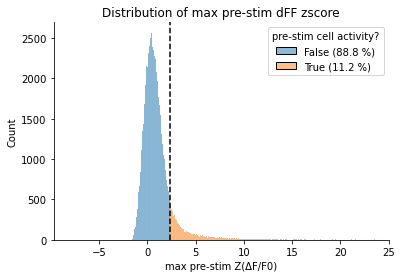

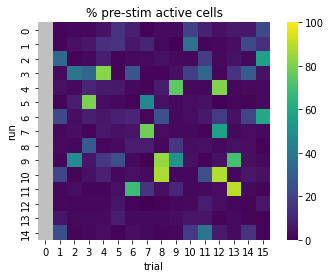

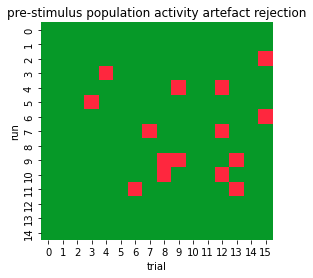

In [24]:
# Identify max dFF z-score in pre-stimulus window for each trial
logger.info('analyzing fluorescence activity in pre-stimulus intervals...')
zscore_prestim = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
Fstats[Label.MAX_ZSCORE_PRESTIM] = zscore_prestim.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).max()

# Classify pre-stimulus state on a per-ROI basis for each trial
Fstats[Label.PRESTIM_ACTIVITY] = Fstats[Label.MAX_ZSCORE_PRESTIM] > ZTHR
npreacts, ntot = Fstats[Label.PRESTIM_ACTIVITY].sum(), len(included(Fstats))
pcts = {True: npreacts / ntot * 1e2, False: (ntot - npreacts) / ntot * 1e2}
logger.info(f'identified {npreacts} trials over {ntot} ({npreacts / ntot * 1e2:.1f} %) with significant pre-stimulus activity')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim_zscore_level_dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(Fstats, x=Label.MAX_ZSCORE_PRESTIM, hue=Label.PRESTIM_ACTIVITY, ax=ax)
ax.axvline(ZTHR, ls='--', c='k')
ax.set_xlim(ax.get_xlim()[0], 25)
ax.set_title('Distribution of max pre-stim dFF zscore')
leg = ax.get_legend()
for t in leg.texts:
    cond = t.get_text() == 'True'
    t.set_text(f'{cond} ({pcts[cond]:.1f} %)')

# Compute and plot fraction of ROIs with pre-stimulus activity for each run & trial
nROIs = len(Fstats.index.unique(level=Label.ROI))
npreacts_per_run_trial = Fstats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum()
isdiscarded = Fstats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
npreacts_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_preacts_per_run_trial = (npreacts_per_run_trial / nROIs * 1e2).rename(Label.PCT_PREACTIVE_CELLS)
figs['pct_prestim_activity_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(Label.PCT_PREACTIVE_CELLS)
sns.heatmap(pct_preacts_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)

# Label trials with large fraction of pre-active cells
from constants import PCT_PREACTIVE_THR
pop_preact_per_run_trial = (pct_preacts_per_run_trial > PCT_PREACTIVE_THR).rename(Label.PRESTIM_POP_ACTIVITY)
npreacts_pop, ntot = pop_preact_per_run_trial.sum(), len(pop_preact_per_run_trial)
logger.info(f'identified {npreacts_pop} / {ntot} trials ({npreacts_pop / ntot * 1e2:.1f}%) with significant pre-stimulus population activity')
exp_pop_preact_per_run_trial = repeat_along_new_dim(
    pop_preact_per_run_trial.to_frame(),
    Label.ROI, Fstats.index.unique(level=Label.ROI)).reorder_levels(
    [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
Fstats[Label.PRESTIM_POP_ACTIVITY] = exp_pop_preact_per_run_trial

# Plot pre-stimulus population activity rejection heatmap
figs['prestim_reject_map'], ax = plt.subplots()
ax.set_title('pre-stimulus population activity artefact rejection')
ax.set_aspect(1.)
sns.heatmap(pop_preact_per_run_trial.unstack(), ax=ax, cmap=rdgn, cbar=False)

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}_labeled'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ir, ax in zip(iROI_inspect, figs[f'zscore_trace_run{irun_inspect}_labeled'].axes):
        # Plot estimated noise range on the z-score traces
        ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
        # Plot pre-stimulus activity threshold and label trials with pre-stim activity
        ax.axhline(ZTHR, ls='--', c='k');
        mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_eq)

### Compute stimlulus-evoked z-score change w.r.t. pre-stim value for each trial

 04/05/2022 20:10:12: extracting mean z-score pre-stim level for each trial...
 04/05/2022 20:10:12: computing relative z-scores changes (w.r.t. pre-stim level) for each trial...
 04/05/2022 20:10:24: applying find_response_peak function to detect events in Z(ΔF/F0) - Z(ΔF/F0)_stim signals across trials in slice(10, 20, None) index window...
 04/05/2022 20:10:29: identified 100551 events over 101025 valid trials (detection rate = 99.5 %)
 04/05/2022 20:10:30: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - all trials...


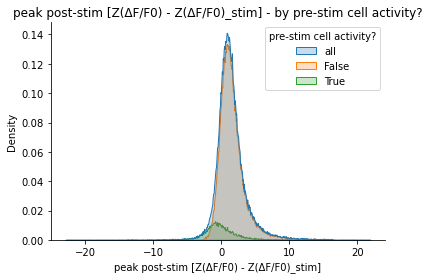

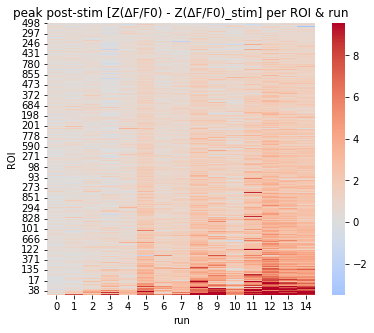

In [25]:
# Extract pre-stimulus z-score level
logger.info('extracting mean z-score pre-stim level for each trial...')
z_onset = zscore_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Subtract pre-stim z-score value to get relative z-score
logger.info('computing relative z-scores changes (w.r.t. pre-stim level) for each trial...')
Ftimeseries[Label.REL_ZSCORE] = (Ftimeseries.loc[:, Label.ZSCORE] - z_onset)

# Identify peak z-score in response window
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] = detect_across_trials(
    find_response_peak, Ftimeseries, FrameIndex.RESPONSE, key=Label.REL_ZSCORE)

# Plot peak z-score histogram
figs[f'peak_rel_zscore_hist'] = plot_stat_histogram(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# Plot average peak z-score per ROI & run
figs[f'peak_rel_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, cmap='coolwarm', nstd=5, sort='ascend')

# # Identify area under the curve in response window
# wlen = FrameIndex.RESPONSE.stop - FrameIndex.RESPONSE.start  # number of frames
# wtime = (wlen - 1) / fps  # time interval (s)
# Fstats[Label.AREA_REL_ZSCORE_POSTSTIM] = detect_across_trials(
#     np.mean, Ftimeseries, FrameIndex.RESPONSE, key=Label.REL_ZSCORE) * wtime # s

# # Plot z-score area under curve histogram
# figs[f'area_rel_zscore_hist'] = plot_stat_histogram(
#     Fstats, Label.AREA_REL_ZSCORE_POSTSTIM, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# # Plot average z-score area under curve per ROI & run
# figs[f'area_rel_zscore_map'] = plot_stat_heatmap(
#     Fstats, Label.AREA_REL_ZSCORE_POSTSTIM, cmap='coolwarm', nstd=5, sort='ascend')

### Visualize correlations between motion artefact, pre and post-stimulus z-score

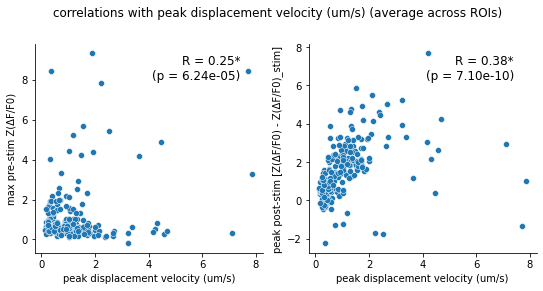

In [26]:
figs['corr_motion_response'] = plot_correlations(
    Fstats, Label.PEAK_DISP_VEL, [Label.MAX_ZSCORE_PRESTIM, Label.PEAK_REL_ZSCORE_POSTSTIM])

### Identify stimulus-evoked responses

 04/05/2022 20:10:30: identifying stimulus-evoked responses...


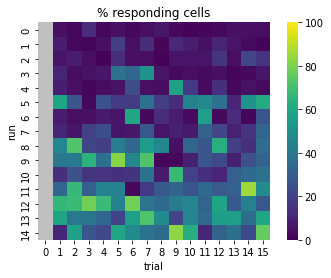

In [27]:
logger.info('identifying stimulus-evoked responses...')
# Identify "proper" responses as those with a z-score above defined threshold 
Fstats[Label.IS_RESP] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] > ZTHR

# Compute and plot fraction of ROIs with stimulus-evoked activity for each run & trial
nROIs = len(Fstats.index.unique(level=Label.ROI))
nresp_per_run_trial = Fstats.loc[:, Label.IS_RESP].groupby([Label.RUN, Label.TRIAL]).sum()
isdiscarded = Fstats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
nresp_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_resp_per_run_trial = (nresp_per_run_trial / nROIs * 1e2).rename(Label.PCT_RESP_CELLS)
figs['pct_resp_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(Label.PCT_RESP_CELLS)
sns.heatmap(pct_resp_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)

# Plot consecutive trials of relative z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}_labeled2'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    # Label trials with pre-stim activity and those with post-stimlus response
    for (ir, ax) in zip(iROI_inspect, figs[f'zscore_trace_run{irun_inspect}_labeled2'].axes):
        # Plot estimated noise range on the z-score traces
        ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
        # Plot pre-stim level and post-stim detection threshold for each trial
        z0 = z_onset.loc[ir, irun_eq]
        istart, z0 = z0.index.values, z0.values
        xstart = stim_delimiters[istart]
        for zoffset, ls in zip([0., ZTHR], [':', ':']): 
            ax.hlines(
                z0 + zoffset, xstart, xstart + NFRAMES_PER_TRIAL,
                colors='k', linestyles=ls, zorder=3)
        # Label trials with pre-stim activity and those with post-stim response
        mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_eq)
        mark_trials(ax, Fstats[Label.IS_RESP], ir, irun_eq, color='C2')

### Compute baseline (spontaneous) deteted events and activity rate

This step is time consuming, therefore results are saved on disk to be loaded on subsequent calls

 04/05/2022 20:10:31: detecting activity events in 50 windows along the trial interval for each trial...


100%|██████████| 50/50 [04:30<00:00,  5.42s/it]


 04/05/2022 20:15:05: saving detected peaks data...
 04/05/2022 20:15:19: removing samples labeled as "discarded"...


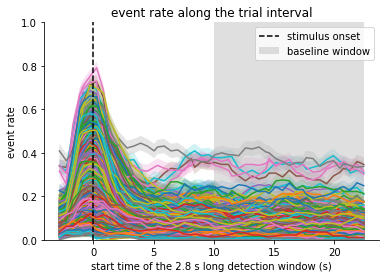

In [28]:
# Detect peaks along trial interval (one alternative would be bootstraping)
from constants import NSEEDS_PER_TRIAL
wlen = FrameIndex.RESPONSE.stop - FrameIndex.RESPONSE.start
peaks_fpath = os.path.join(postpro_outdir, f'peaks_along_trial_zthr{ZTHR:.3f}_wlen{wlen}_{NSEEDS_PER_TRIAL}seeds.csv')
peaks = get_peaks_along_trial(peaks_fpath, Ftimeseries, wlen, NSEEDS_PER_TRIAL)
peaks[Label.EVENT] = peaks[Label.PEAK_ZSCORE] > ZTHR

# Plot variation in activity rate over trial interval
varkey = 'sem'
tbounds_baseline = (10., None)
figs['activity_along_trial'], baseline_activity_rate = plot_metrics_along_trial(
    included(peaks)[Label.EVENT], wlen, 1 / daq_settings['framePeriod'], varkey=varkey,
    tbounds_baseline=tbounds_baseline)

# Add baseline information to Fstats
Fstats = expand_and_add(baseline_activity_rate, Fstats, prefix='baselineSR')

# # Plot variation in baseline (spontaneous) activity rate over time
# figs['activity_over_time'], ax = plt.subplots()
# sns.despine(ax=ax)
# ax.set_title('variation of activity rate over time')
# ax.set_xlabel('# trial')
# ax.set_ylabel('activity rate')
# ax.set_ylim(0, 1)
# baseline_rate_per_trial = included(peaks)[Label.EVENT].groupby([Label.TRIAL, Label.ISTART]).mean().groupby(Label.TRIAL).median()
# stimevoked_rate_per_trial = included(Fstats)[Label.IS_RESP].groupby(Label.TRIAL).mean()
# ax.plot(baseline_rate_per_trial.index, baseline_rate_per_trial.values, label='baseline')
# ax.plot(stimevoked_rate_per_trial.index, stimevoked_rate_per_trial.values, label='stimulus-evoked')
# ax.legend();

### Inspect response success rate

 04/05/2022 20:15:22: removing samples labeled as "discarded"...
 04/05/2022 20:15:22: discarding samples with significant motion artefact...
 04/05/2022 20:15:22: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:22: discarding samples with pre-stimulus population activity...
 04/05/2022 20:15:22: plotting trial-averaged success rate per ROI & run - all trials...
 04/05/2022 20:15:22: removing samples labeled as "discarded"...
 04/05/2022 20:15:22: discarding samples with significant motion artefact...
 04/05/2022 20:15:22: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:22: discarding samples with pre-stimulus population activity...
 04/05/2022 20:15:23: plotting trial-averaged success rate - all trials...
 04/05/2022 20:15:23: removing samples labeled as "discarded"...
 04/05/2022 20:15:23: discarding samples with significant motion artefact...
 04/05/2022 20:15:23: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:23: discarding 

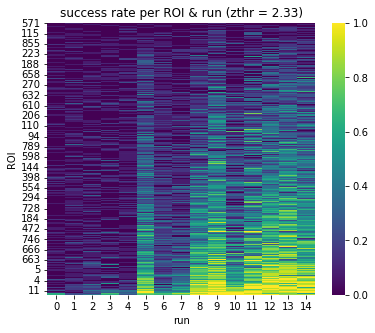

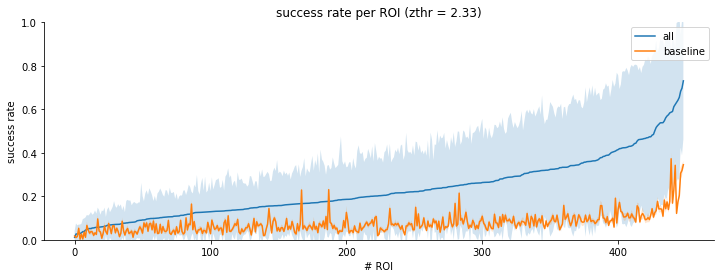

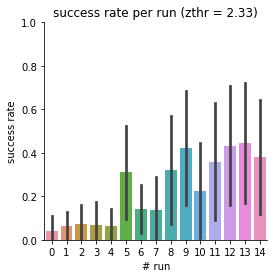

In [29]:
# Plot success rate per ROI & run
figs[f'sr_map'] = plot_stat_heatmap(
    valid(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}', cmap='viridis', sort='ascend')
# Plot success rate per ROI
figs['sr_per_ROI'] = plot_stat_per_ROI(
    valid(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}', sort='ascend', baseline_key='baselineSR')
# Plot success rate per run
figs['sr_per_run'] = plot_stat_per_run(
    valid(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}')

### Identify responsive conditions per ROI based on their stimulation-evoked succes rate

 04/05/2022 20:15:24: removing samples labeled as "discarded"...
 04/05/2022 20:15:24: discarding samples with significant motion artefact...
 04/05/2022 20:15:24: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:24: discarding samples with pre-stimulus population activity...
 04/05/2022 20:15:35: threshold z-score for success rate: zthr = 1.96


<AxesSubplot:title={'center':'significant Z(success rate) map'}, xlabel='run', ylabel='ROI'>

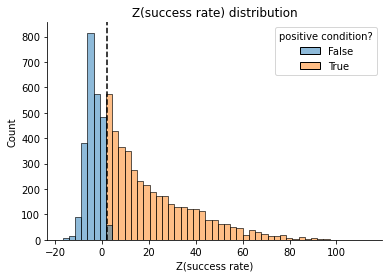

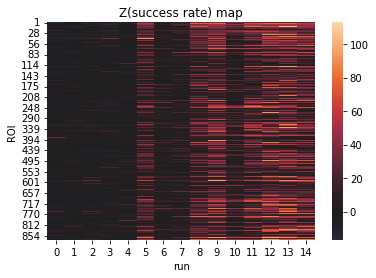

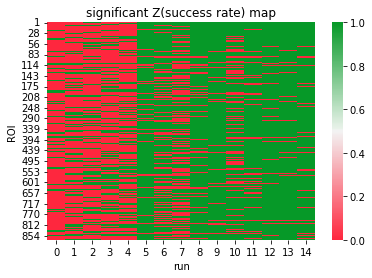

In [30]:
# Compute temporary trial-averaged stats to get success rates and baseline metrics per ROI & run
trialavg_tmp = get_trial_averaged(valid(Fstats))
sr_stats = trialavg_tmp[Label.SUCCESS_RATE].to_frame()
# Compute z-score for success rates per ROI & run
sr_stats[Label.ZSCORED_SUCCESS_RATE] = (trialavg_tmp[Label.SUCCESS_RATE] - trialavg_tmp[Label.BASELINE_MEAN]) / trialavg_tmp[Label.BASELINE_STD]
# Get threshold z-score for success rate classification
zthr = pvalue_to_zscore(.05, directional=False)
logger.info(f'threshold z-score for success rate: zthr = {zthr:.2f}')
# Classify significant z-scored SRs as responsive conditions
sr_stats[Label.POS_COND] = sr_stats[Label.ZSCORED_SUCCESS_RATE] > zthr
# Add success rates, z-score and responsiveness condition status to Fstats
expand_and_add(sr_stats, Fstats)

# Plot z-scored SR histogram distribution
figs['Z(SR) distribution'], ax = plt.subplots()
ax.set_title(f'{Label.ZSCORED_SUCCESS_RATE} distribution')
sns.histplot(sr_stats, x=Label.ZSCORED_SUCCESS_RATE, hue=Label.POS_COND, ax=ax)
ax.axvline(zthr, c='k', ls='--')
sns.despine(ax=ax)

# Plot z-scored SR heatmap
figs['Z(SR) heatmap'], ax = plt.subplots()
ax.set_title(f'{Label.ZSCORED_SUCCESS_RATE} map')
sns.heatmap(sr_stats[Label.ZSCORED_SUCCESS_RATE].unstack(), ax=ax, center=0)

# Plot positive conditions heatmap
figs['resp heatmap'], ax = plt.subplots()
ax.set_title(f'significant {Label.ZSCORED_SUCCESS_RATE} map')
sns.heatmap(sr_stats[Label.POS_COND].unstack(), ax=ax, cmap=gnrd)

### Identify responsive cells based on their number of responsive conditions

 04/05/2022 20:15:36: identified 423/449 (94.2 %) responding cells


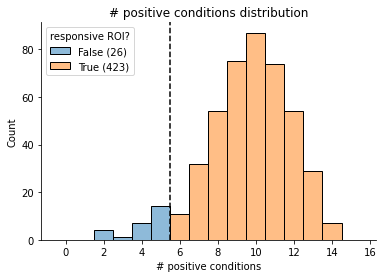

In [31]:
# Compute number of significant conditions per ROI
nposconds = sr_stats[Label.POS_COND].groupby(Label.ROI).sum().rename(Label.NPOS_CONDS)
respstats = nposconds.to_frame()

# Classify ROIs based on number of responsive conditions
from constants import NPOSCONDS_THR
respstats[Label.IS_RESP_ROI] = nposconds >= NPOSCONDS_THR

# Add respstats to Fstats
expand_and_add(respstats, Fstats)

# Temporary: classify cells only based on responsiveness 
Fstats[Label.ROI_RESP_TYPE] = Fstats[Label.IS_RESP_ROI].map(
    {True: 'responsive', False: 'non-responsive'})

# Log number and percentage of responding cells identified
ncells_per_cond = {k: sum(respstats[Label.IS_RESP_ROI] == k) for k in [True, False]}
nresp = ncells_per_cond[True]
ntot = len(respstats)
logger.info(f'identified {nresp}/{ntot} ({nresp / ntot * 100:.1f} %) responding cells')

# Plot histogram distribution of # responsive conditions per type
figs['nposconds histogram'], ax = plt.subplots()
ax.set_title(f'{Label.NPOS_CONDS} distribution')
sns.histplot(respstats, x=Label.NPOS_CONDS, bins=np.arange(nruns + 2) - 0.5, ax=ax,
             hue=Label.IS_RESP_ROI, hue_order=[False, True])
ax.axvline(NPOSCONDS_THR - 0.5, c='k', ls='--')
sns.despine(ax=ax)
leg = ax.get_legend()
for t in leg.texts:
    txt = t.get_text()
    b = txt == 'True'
    t.set_text(f'{txt} ({ncells_per_cond[b]})')

### Classify cells according to parameter-dependency of their response

In [32]:
# # Compute pressure and duty cycle dependency of peak-zscores for each cell, using 1-way ANOVA
# xkeys = [Label.P, Label.DC]
# ykey = Label.PEAK_REL_ZSCORE_POSTSTIM
# probs = {}
# for xkey in xkeys:
#     k = f'p({ykey} ~ {xkey})'
#     logger.info(f'computing {ykey} dependency on {xkey} across ROIs...')
#     probs[f'p({ykey} ~ {xkey})'] = get_xdep_data(Fstats, xkey).groupby(Label.ROI).apply(
#         lambda df: anova1d(df, xkey, ykey))
# probs = pd.DataFrame(probs)
# pkeys = probs.columns.values

# # Classify response types according to P & DC dependencies
# from constants import PTHR_DEPENDENCY
# PTHR_DEPENDENCY = 0.5
# logger.info('classifying ROIs response type...')
# for xkey, pkey in zip(xkeys, pkeys):
#     probs[f'{xkey}-dep'] = probs[pkey] <= PTHR_DEPENDENCY
# probs[Label.ROI_RESP_TYPE] = correlations_to_rcode(probs[[f'{k}-dep' for k in xkeys]])
# newdims = {k: Fstats.index.unique(level=k) for k in [Label.RUN, Label.TRIAL]}
# for k in probs:
#     logger.info(f'adding {k} to Fstats...')
#     Fstats[k] = repeat_along_new_dims(probs[[k]], newdims)
# rtypes = get_default_rtypes()

# # Plot p-values distribution of each ROI, color-coded by type
# figs['pvalues_per_rtype'] = plot_pvalues_per_response_type(
#     probs.copy(), *pkeys, scale='log', pthr=PTHR_DEPENDENCY)

### Extract trial-averaged stats

In [33]:
logger.info('computing trial-averaged Fstats...')
trialavg_stats = get_trial_averaged(valid(Fstats).loc[:, [
    Label.LINE, Label.NPERTRIAL, Label.DUR, Label.FPS,
    Label.RUNID, Label.P, Label.DC, Label.ISPPA, Label.ISPTA,
    Label.SUCCESS_RATE, Label.ZSCORED_SUCCESS_RATE, Label.POS_COND,
    Label.NPOS_CONDS, Label.IS_RESP_ROI, Label.ROI_RESP_TYPE]])
trialavg_stats

 04/05/2022 20:15:36: computing trial-averaged Fstats...
 04/05/2022 20:15:36: removing samples labeled as "discarded"...
 04/05/2022 20:15:36: discarding samples with significant motion artefact...
 04/05/2022 20:15:36: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:36: discarding samples with pre-stimulus population activity...


line  trial_length  duration (s)   fps  run ID  P (MPa)  DC (%)  \
ROI run                                                                     
1   0    line3         100.0           0.2  3.56   869.0     0.00    50.0   
    1    line3         100.0           0.2  3.56   867.0     0.10    50.0   
    2    line3         100.0           0.2  3.56   866.0     0.20    50.0   
    3    line3         100.0           0.2  3.56   865.0     0.40    50.0   
    4    line3         100.0           0.2  3.56   868.0     0.05    50.0   
...        ...           ...           ...   ...     ...      ...     ...   
878 10   line3         100.0           0.2  3.56   856.0     0.80    40.0   
    11   line3         100.0           0.2  3.56   855.0     0.80    50.0   
    12   line3         100.0           0.2  3.56   861.0     0.80    60.0   
    13   line3         100.0           0.2  3.56   862.0     0.80    70.0   
    14   line3         100.0           0.2  3.56   863.0     0.80    80.0   

         I_SPPA (W/cm2)  I_SPTA (W/cm2)  success rate  Z(success rate)  \
ROI run                                                                  
1   0          0.000000        0.000000      0.000000        -8.808271   
    1          0.309132        0.154566      0.076923        -4.977848   
    2          1.236530        0.618265      0.333333         7.790229   
    3          4.946119        2.473059      0.100000        -3.828721   
    4          0.077283        0.038642      0.181818         0.245457   
...                 ...             ...           ...              ...   
878 10        19.784475        7.913790      0.545455        47.403306   
    11        19.784475        9.892238      0.545455        47.403306   
    12        19.784475       11.870685      1.000000        93.890909   
    13        19.784475       13.849133      0.769231        70.289510   
    14        19.784475       15.827580      0.909091        84.593388   

         positive condition?  # positive conditions  responsive ROI?  \
ROI run                                                                
1   0                    0.0                   11.0              1.0   
    1                    0.0                   11.0              1.0   
    2                    1.0                   11.0              1.0   
    3                    0.0                   11.0              1.0   
    4                    0.0                   11.0              1.0   
...                      ...                    ...              ...   
878 10                   1.0                   12.0              1.0   
    11                   1.0                   12.0              1.0   
    12                   1.0                   12.0              1.0   
    13                   1.0                   12.0              1.0   
    14                   1.0                   12.0              1.0   

        response type  
ROI run                
1   0      responsive  
    1      responsive  
    2      responsive  
    3      responsive  
    4      responsive  
...               ...  
878 10     responsive  
    11     responsive  
    12     responsive  
    13     responsive  
    14     responsive  

[6735 rows x 15 columns]

## Results visualization

### Spatial distribution of cells per response type

 04/05/2022 20:15:45: plotting cells map color-coded by response type...
 04/05/2022 20:15:45: extracting responses types per ROI...


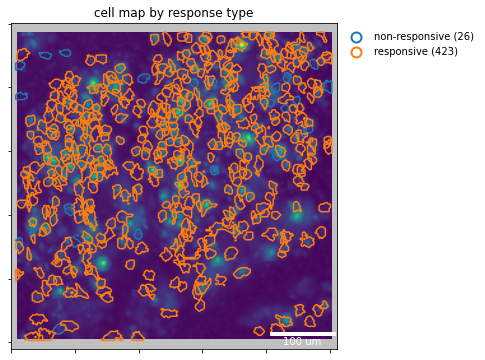

In [34]:
figs['cellmap'] = plot_cell_map(
    ROI_masks, trialavg_stats, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='Vcorr', mode='contour')

### Success rate parameter dependency per cell type 

 04/05/2022 20:15:47: sub-indexing data...
 04/05/2022 20:15:47: filtering data...
 04/05/2022 20:15:47: cross-checking filters...
 04/05/2022 20:15:47: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 04/05/2022 20:15:47: sub-indexing data...
 04/05/2022 20:15:47: filtering data...
 04/05/2022 20:15:47: cross-checking filters...
 04/05/2022 20:15:47: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. DC (%) ...
 04/05/2022 20:15:47: sub-indexing data...
 04/05/2022 20:15:47: filtering data...
 04/05/2022 20:15:47: cross-checking filters...
 04/05/2022 20:15:47: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(success rate) vs. P (MPa) ...
 04/05/2022 20:15:47: sub-indexing data...
 04/05/2022 20:15:47: filtering data...
 04/05/2022 20:15:47: cross-checking filters...
 04/05/2022 20:15:47: grouping by response type, averagin

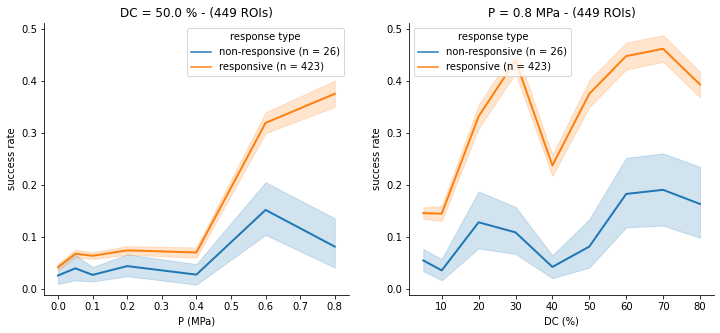

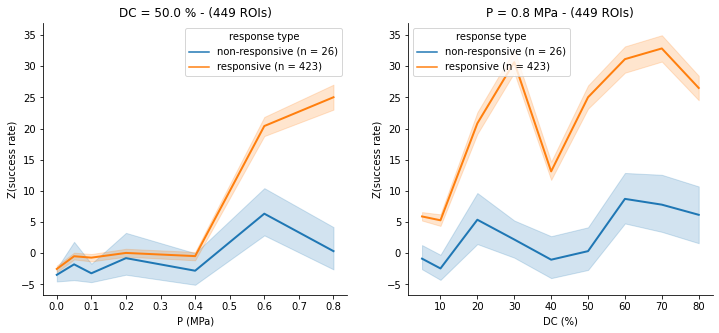

In [35]:
for ykey in [Label.SUCCESS_RATE, Label.ZSCORED_SUCCESS_RATE]:
    figs[f'{ykey}_dependency'] = plot_stimparams_dependency_per_response_type(
        trialavg_stats, ykey)

### Optional: restrict analysis to subset of trials for each cell 

In [36]:
# # If specified, select subset of responses that lie within specific quantile interval for each category & run
# from constants import ZSCORE_QUANTILE_INTERVAL
# subset_idx = get_quantile_indexes(
#     valid(Fstats),
#     ZSCORE_QUANTILE_INTERVAL,
#     Label.PEAK_REL_ZSCORE_POSTSTIM,
#     groupby=[Label.ROI_RESP_TYPE, Label.RUN])

### Compute average timecourses across valid trials

In [37]:
# Adding validity labels to Ftimeseries and selecting only valid index
logger.info('generating expanded validity indexes...')
exp_validity_labels = repeat_along_new_dim(
    Fstats[[Label.DISCARDED, Label.MOTION, Label.PRESTIM_ACTIVITY, Label.PRESTIM_POP_ACTIVITY]],
    Label.FRAME, Ftimeseries.index.unique(level=Label.FRAME))
valid_Ftimeseries = valid(pd.concat([Ftimeseries, exp_validity_labels], axis=1))[[*Ftimeseries.columns]]

# Trial-averaging
logger.info('computing trial-averaged time traces per ROI & run...') 
avg_Ftimeseries = Ftimeseries.groupby([Label.ROI, Label.RUN, Label.FRAME]).mean()

 04/05/2022 20:15:48: generating expanded validity indexes...
 04/05/2022 20:15:54: removing samples labeled as "discarded"...
 04/05/2022 20:15:54: discarding samples with significant motion artefact...
 04/05/2022 20:15:54: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:55: discarding samples with pre-stimulus population activity...
 04/05/2022 20:15:55: computing trial-averaged time traces per ROI & run...


### Response strength (peak-zscore) dependency on cell response type

#### 1. trial-averaged peak of individual z-score traces

 04/05/2022 20:15:56: removing samples labeled as "discarded"...
 04/05/2022 20:15:56: discarding samples with significant motion artefact...
 04/05/2022 20:15:56: discarding samples with pre-stimulus activity...
 04/05/2022 20:15:56: discarding samples with pre-stimulus population activity...
 04/05/2022 20:15:57: sub-indexing data...
 04/05/2022 20:15:57: filtering data...
 04/05/2022 20:15:57: cross-checking filters...
 04/05/2022 20:15:57: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. P (MPa) ...
 04/05/2022 20:15:57: sub-indexing data...
 04/05/2022 20:15:57: filtering data...
 04/05/2022 20:15:57: cross-checking filters...
 04/05/2022 20:15:57: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. DC (%) ...


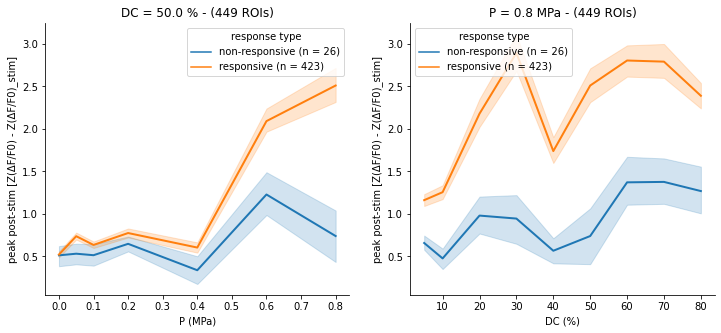

In [38]:
trialavg_stats[Label.PEAK_REL_ZSCORE_POSTSTIM] = get_trial_averaged(valid(Fstats)[Label.PEAK_REL_ZSCORE_POSTSTIM])
figs['peak_zscore_dependency1'] = plot_stimparams_dependency_per_response_type(
    trialavg_stats, Label.PEAK_REL_ZSCORE_POSTSTIM)

#### 2.peak of trial-averaged z-scored traces

 04/05/2022 20:15:57: computing peaks within response window on trial-average z-score traces...
 04/05/2022 20:15:58: sub-indexing data...
 04/05/2022 20:15:58: filtering data...
 04/05/2022 20:15:58: cross-checking filters...
 04/05/2022 20:15:58: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. P (MPa) ...
 04/05/2022 20:15:58: sub-indexing data...
 04/05/2022 20:15:58: filtering data...
 04/05/2022 20:15:58: cross-checking filters...
 04/05/2022 20:15:58: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. DC (%) ...


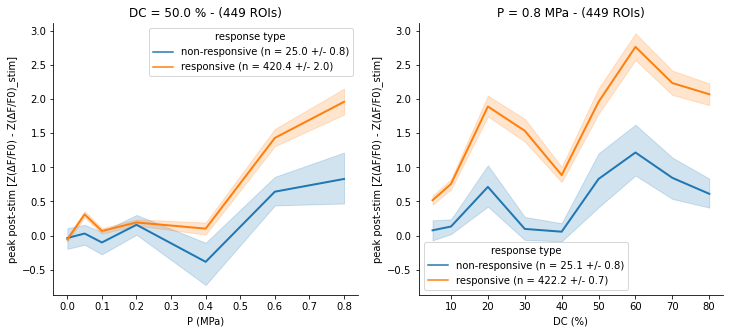

In [39]:
logger.info('computing peaks within response window on trial-average z-score traces...')
trialavg_stats[Label.PEAK_REL_ZSCORE_POSTSTIM] = avg_Ftimeseries.loc[
    pd.IndexSlice[:, :, FrameIndex.RESPONSE], Label.REL_ZSCORE].groupby(
    [Label.ROI, Label.RUN]).agg(find_response_peak)
figs['peak_zscore_dependency2'] = plot_stimparams_dependency_per_response_type(
    trialavg_stats, Label.PEAK_REL_ZSCORE_POSTSTIM)

### Save trial-averaged stats to disk

In [40]:
trialavg_stats.to_csv(os.path.join(get_stats_dir(), f'{mouse}_{region}.csv'))

### Prepare traces data table

In [41]:
# Expand Fstats
logger.info('expanding Fstats along frame dimension...')
exp_stats = repeat_along_new_dim(trialavg_stats, Label.FRAME, index_dims[Label.FRAME])
# Merge datasets
logger.info('merging datasets...')
data = pd.concat([avg_Ftimeseries, exp_stats], axis=1)
# Add time to dataset
data = add_time_to_table(data)
# Select data subset for plots
plt_data = data
# plt_data = get_data_subset(valid(data), subset_idx)

 04/05/2022 20:15:58: expanding Fstats along frame dimension...
 04/05/2022 20:15:59: merging datasets...
 04/05/2022 20:15:59: adding time info to table...


### Response type, pressure & duty cycle dependency, per category

 04/05/2022 20:15:59: sub-indexing data...
 04/05/2022 20:15:59: filtering data...
 04/05/2022 20:15:59: cross-checking filters...
 04/05/2022 20:15:59: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 04/05/2022 20:16:04: sub-indexing data...
 04/05/2022 20:16:04: filtering data...
 04/05/2022 20:16:04: cross-checking filters...
 04/05/2022 20:16:04: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 04/05/2022 20:16:13: sub-indexing data...
 04/05/2022 20:16:13: filtering data...
 04/05/2022 20:16:13: cross-checking filters...
 04/05/2022 20:16:13: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...


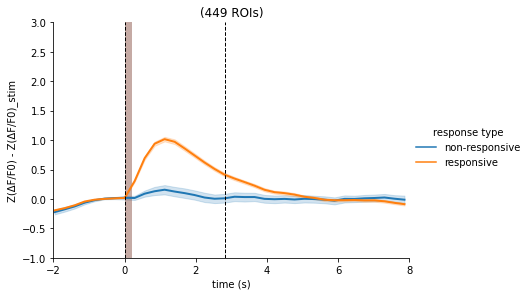

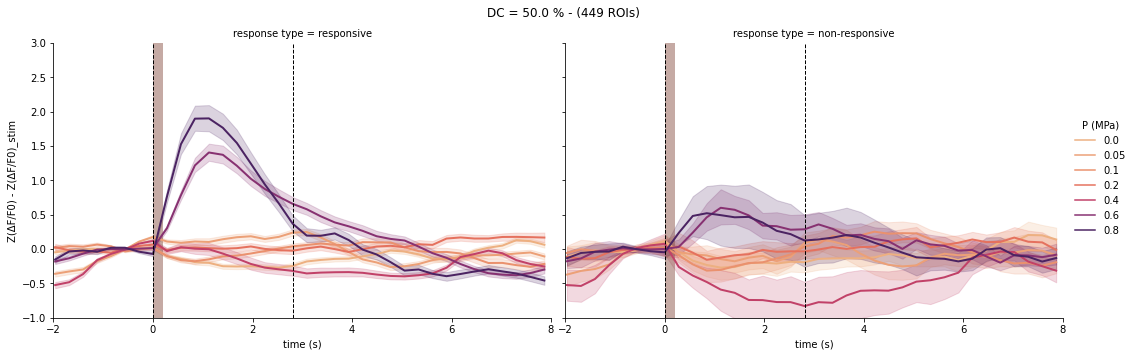

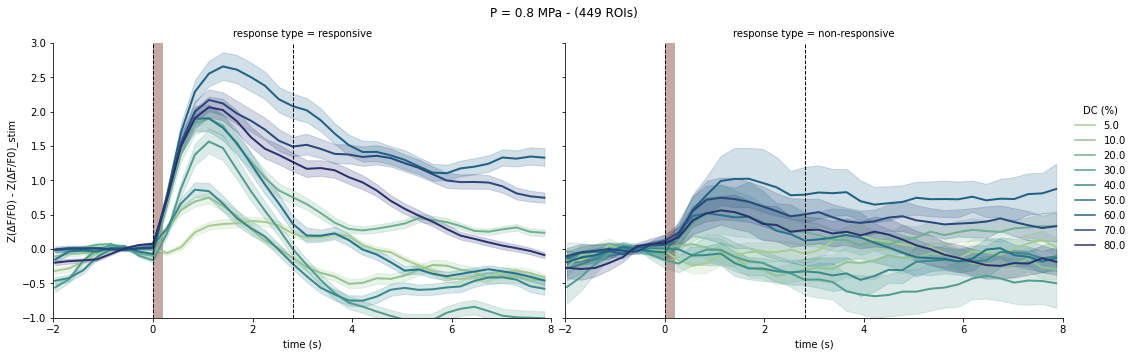

In [42]:
# Plotting arguments
tracekwargs = dict(
    ykey = Label.REL_ZSCORE,
    tbounds = [-2, 8.],  # s
    ybounds = [-1, 3],   # z-score unit
)
# Across conditions
figs[f'responses_{ykey}_by_type'] = plot_responses(
    plt_data, hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes(), **tracekwargs)
# Pressure dependency
figs[f'responses_{ykey}_by_type_DC{DC_REF}%'] = plot_responses(
    plt_data, DC=DC_REF, hue=Label.P, col=Label.ROI_RESP_TYPE, **tracekwargs)
# Duty cycle dependency
figs[f'responses_{ykey}_by_type_P{P_REF}MPa'] = plot_responses(
    plt_data, P=P_REF, hue=Label.DC, col=Label.ROI_RESP_TYPE, **tracekwargs)

### Visualize (ROI, run) combinations with best success rate

In [43]:
# # Group by ROI and run, take first, sort by success rate, and select n bests 
# sr = valid(Fstats)[Label.IS_RESP].groupby([Label.ROI, Label.RUN]).mean()
# best_sr = sr.sort_values(ascending=False).head(3)
# logger.info(f'identified combinations with best success rate:\n{best_sr}')
# ibests = best_sr.index.values
# figs['best_responders'], axes = plt.subplots(len(ibests), 1, figsize=(5, len(ibests) * 4))
# for comb, ax in zip(ibests, axes):
#     fig = plot_responses(
#         plt_data, iROI=comb[0], irun=comb[1],
#         alltraces=True, ykey=Label.REL_ZSCORE, label=Label.SUCCESS_RATE,
#         mark_peaks=True, ci=None,
#         tbounds=tbounds_response, ax=ax)
# fig.suptitle(f'(ROI x condition) combinations with {len(ibests)} best success rates')
# fig.tight_layout()

### Save figures

In [44]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix=figsprefix)

# Save stacks as GIFs if specified
if irun_inspect is not None and save_gifs:
    #raw and fileted stacks from specific run
    save_stack_to_gif(
        figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run)
    # registered stack (slice corresponding to specific run)
    save_stack_to_gif(
        figsdir, s2p_ops, title=outstack_label,
        ilabels=istimframes_stacked, bounds=runbounds)

 04/05/2022 20:16:24: saving figure "dataset_info" on page 0
 04/05/2022 20:16:24: saving figure "registered_offsets" on page 1
 04/05/2022 20:16:24: saving figure "phasecorrpeak_over_time" on page 2
 04/05/2022 20:16:24: saving figure "PCdrifts" on page 3
 04/05/2022 20:16:24: saving figure "registered_images" on page 4
 04/05/2022 20:16:24: saving figure "sparse_maps" on page 5
 04/05/2022 20:16:25: saving figure "identified_ROIs" on page 6
 04/05/2022 20:16:25: saving figure "ROI_prob_dists" on page 7
 04/05/2022 20:16:25: saving figure "filtered_ROIs" on page 8
 04/05/2022 20:16:25: saving figure "F_ROI_traces_allROIs" on page 9
 04/05/2022 20:16:33: saving figure "raw_F_traces" on page 10
 04/05/2022 20:16:33: saving figure "alphas" on page 11
 04/05/2022 20:16:33: saving figure "F_trace" on page 12
 04/05/2022 20:16:34: saving figure "F_traces_allROIs" on page 13
 04/05/2022 20:16:41: saving figure "gaussianfits_dists" on page 14
 04/05/2022 20:16:42: saving figure "protocol_summ

### Notify upon completion

In [45]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 04/05/2022 20:16:54: notebook completed in 0:10:16.258791 s
